# **makemore** character level language model

### reading and exploring the dataset

In [1]:
words = open('names.txt', 'r').read()
words = words.splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [2]:
len(words)

32033

In [3]:
max(len(word) for word in words), min(len(word) for word in words)

(15, 2)

### counting bigrams in a 2D torch tensor

In [4]:
chars = sorted(list(set(''.join(words))))

# look-up table
stoi = {s:i for i, s in enumerate(chars)}
stoi['<S>'] = 26
stoi['<E>'] = 27
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '<S>': 26,
 '<E>': 27}

In [5]:
import torch
N = torch.zeros((28, 28), dtype=torch.int32)

for word in words:
  chs = ['<S>'] + list(word) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    ind1 = stoi[ch1]
    ind2 = stoi[ch2]

    N[ind1][ind2] +=1

N

tensor([[ 556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568, 2528,
         1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,  182,
         2050,  435,    0, 6640],
        [ 321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,  103,
            0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,    0,
           83,    0,    0,  114],
        [ 815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,  116,
            0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,    3,
          104,    4,    0,   97],
        [1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,   60,
           30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,    0,
          317,    1,    0,  516],
        [ 679,  121,  153,  384, 1271,   82,  125,  152,  818,   55,  178, 3248,
          769, 2675,  269,   83,   14, 1958,  861,  580,   69,  463,   50,  132,
         1070,  181,    0, 3983],
        [ 242,    0,

### visualizing the bigram tensor

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

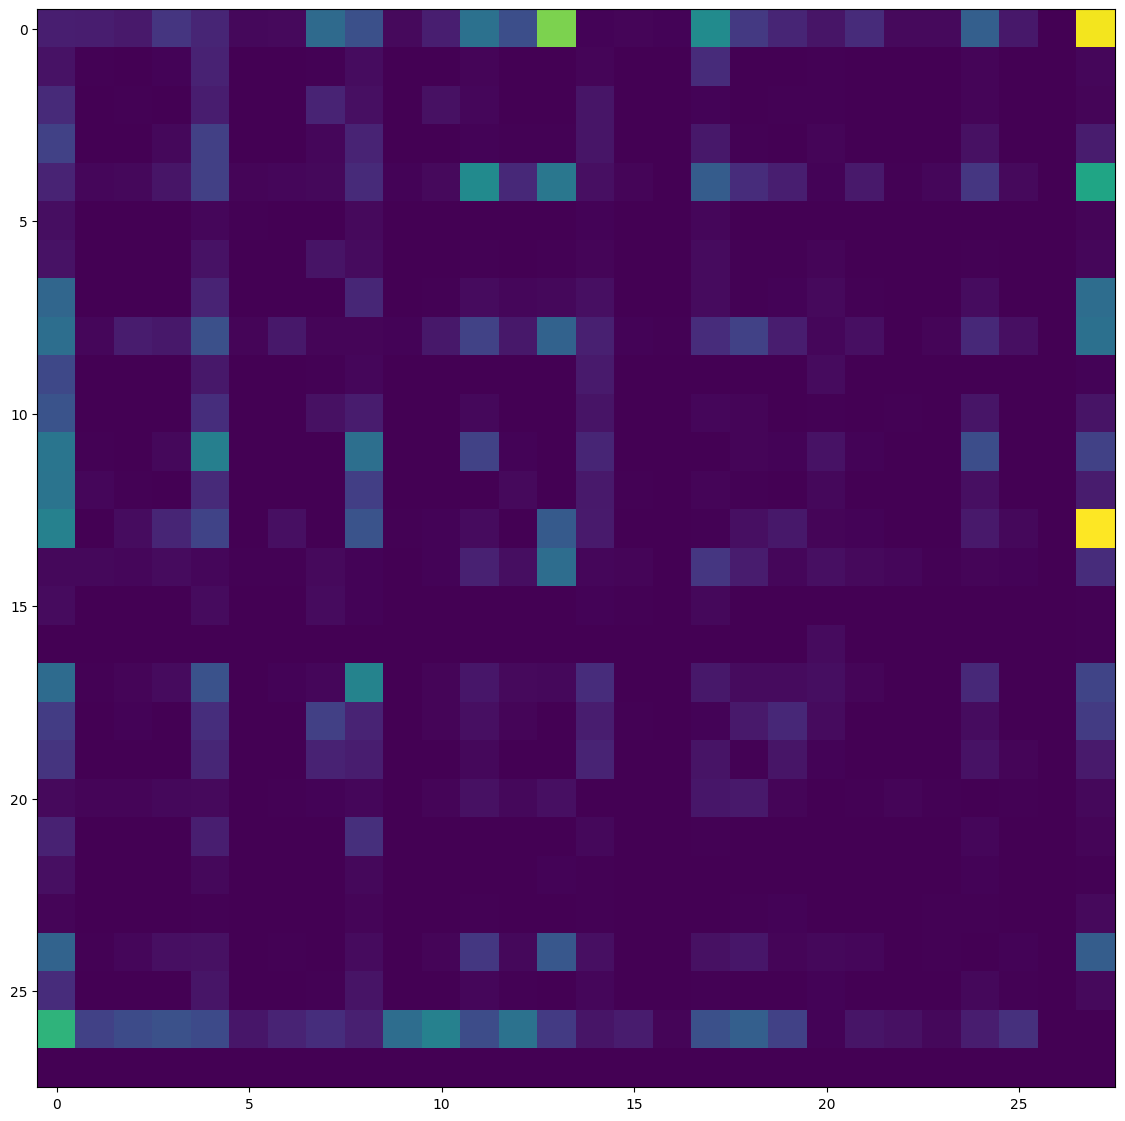

In [7]:
plt.figure(figsize=(14, 14))
plt.imshow(N);

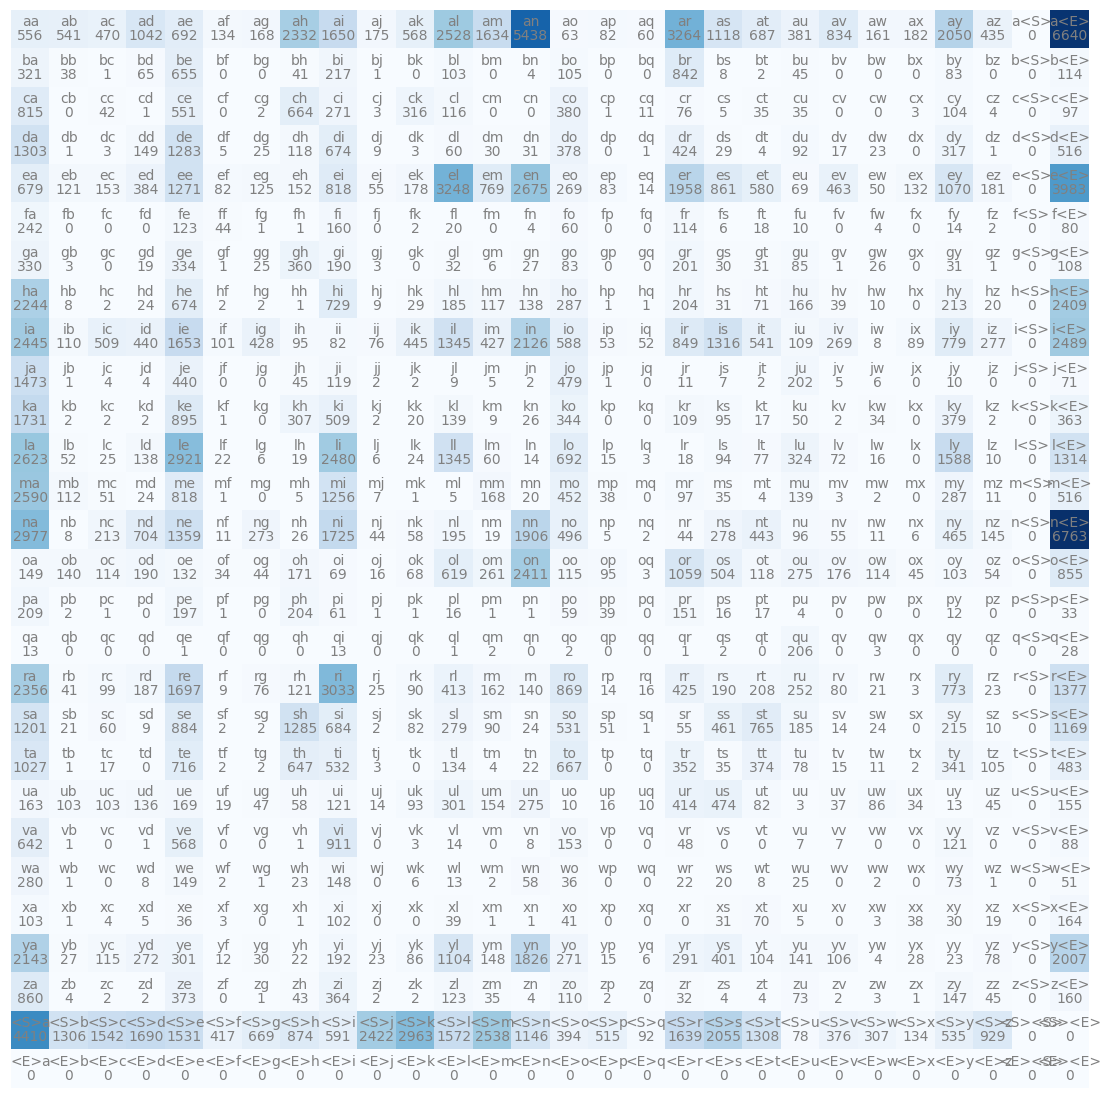

In [8]:
itos = {i:s for s, i in stoi.items()}

plt.figure(figsize=(14, 14))
plt.imshow(N, cmap='Blues')
for i in range(28):
  for j in range(28):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
    plt.text(j, i, N[i][j].item(), ha='center', va='top', color='gray')

plt.axis('off');